In [1]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

df = pd.read_csv('AI_Resume_Screening.csv')

Saving AI_Resume_Screening.csv to AI_Resume_Screening.csv


In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

print(df.head())
print(df.columns)
print(df['Recruiter Decision'].value_counts())
print(df['Job Role'].value_counts())

   Resume_ID              Name                                        Skills  \
0          1        Ashley Ali                      TensorFlow, NLP, Pytorch   
1          2      Wesley Roman  Deep Learning, Machine Learning, Python, SQL   
2          3     Corey Sanchez         Ethical Hacking, Cybersecurity, Linux   
3          4  Elizabeth Carney                   Python, Pytorch, TensorFlow   
4          5        Julie Hill                              SQL, React, Java   

   Experience (Years) Education                Certifications  \
0                  10      B.Sc                           NaN   
1                  10       MBA                     Google ML   
2                   1       MBA  Deep Learning Specialization   
3                   7    B.Tech                 AWS Certified   
4                   4       PhD                           NaN   

                Job Role Recruiter Decision  Salary Expectation ($)  \
0          AI Researcher               Hire              

In [3]:
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import re

# --- 1. Label Encoding ---
df['label'] = df['Recruiter Decision'].map({'Hire': 1, 'Reject': 0})

# --- 2. Clean text function ---
def clean_text(s):
    s = str(s).lower()
    s = re.sub(r'[^a-z0-9 ]', '', s)
    s = re.sub(r'\s+', ' ', s)
    return s.strip()

# --- 3. Fill & clean Skills, Certs, and Job Role ---
df['Skills'] = df['Skills'].fillna('none').apply(clean_text)
df['Certifications'] = df['Certifications'].fillna('none').apply(clean_text)
df['Job Role'] = df['Job Role'].fillna('none').apply(clean_text)

# --- 4. Combine all text fields ---
df['combined_text'] = df['Skills'] + ' ' + df['Certifications'] + ' ' + df['Job Role']

# --- 5. TF-IDF Vectorizer on combined text ---
text_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1
)
text_vec = text_vectorizer.fit_transform(df['combined_text'])

# --- 6. Encode education ---
le = LabelEncoder()
df['Education_encoded'] = le.fit_transform(df['Education'].fillna('Unknown'))

# --- 7. Prepare numeric features ---
df['Experience (Years)'] = df['Experience (Years)'].fillna(0)
df['Projects Count'] = df['Projects Count'].fillna(0)

experience = df[['Experience (Years)']].astype(float).values
education = df[['Education_encoded']].astype(float).values
projects = df[['Projects Count']].astype(float).values

# --- 8. Scale numeric ---
scaler = StandardScaler()
experience_scaled = scaler.fit_transform(experience)
projects_scaled = scaler.fit_transform(projects)

# --- 9. Convert to sparse ---
experience_sparse = sparse.csr_matrix(experience_scaled)
education_sparse = sparse.csr_matrix(education)
projects_sparse = sparse.csr_matrix(projects_scaled)

# --- 10. Combine final feature matrix ---
X = sparse.hstack([text_vec, experience_sparse, education_sparse, projects_sparse])
y = df['label'].values

# --- 11. Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- 12. Train classifier (XGBoost used here) ---
clf = XGBClassifier(
    n_estimators=100,
    scale_pos_weight=(y == 0).sum() / (y == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)
clf.fit(X_train, y_train)

# --- 13. Predict and evaluate ---
y_pred = clf.predict(X_test)
print("X shape:", X.shape)
print(classification_report(y_test, y_pred))


X shape: (1000, 136)
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        38
           1       0.99      0.95      0.97       162

    accuracy                           0.95       200
   macro avg       0.91      0.96      0.93       200
weighted avg       0.96      0.95      0.96       200



                      feature  importance
133                Experience    0.270198
67   networking cybersecurity    0.193754
65                 networking    0.123582
135                  Projects    0.090015
2                     analyst    0.025912
84                python deep    0.025759
47           learning machine    0.023391
71           networking linux    0.022409
49    learning specialization    0.020766
0                          ai    0.018832
10              cybersecurity    0.017948
55              linux ethical    0.017786
30      hacking cybersecurity    0.017222
8              certified data    0.016478
58                    machine    0.015248
26                     google    0.015032
80                     python    0.014578
115                       sql    0.013297
24                    ethical    0.011314
3                         aws    0.010941


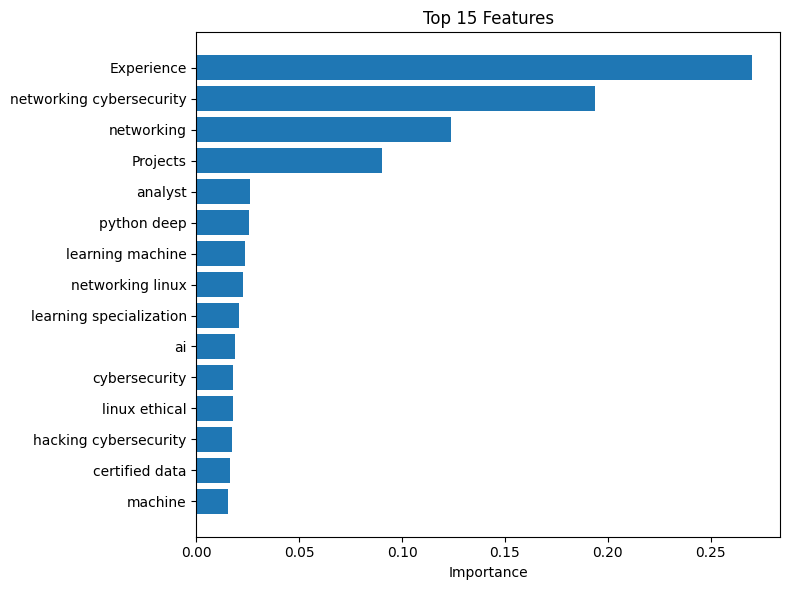

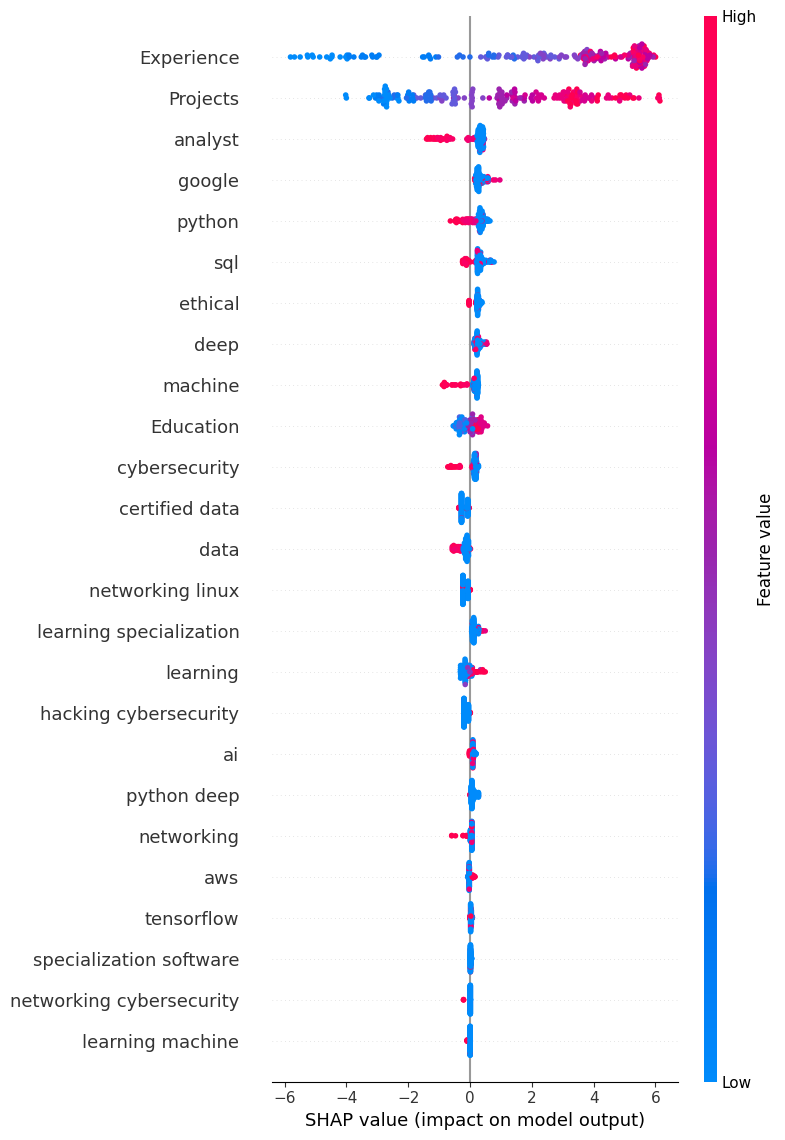

In [4]:
import matplotlib.pyplot as plt
import shap
importances = clf.feature_importances_
feature_names = text_vectorizer.get_feature_names_out().tolist() + ['Experience', 'Education', 'Projects']

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 20
print(importance_df.head(20))
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
plt.xlabel('Importance')
plt.title(f'Top {top_n} Features')
plt.tight_layout()
plt.show()

# Convert X_train to dense array (sampled for memory efficiency)
X_sample = X_train[:200].toarray()

# Create SHAP TreeExplainer for XGBoost
explainer = shap.TreeExplainer(clf)

# Compute SHAP values for positive class (Hire = 1)
shap_values = explainer.shap_values(X_sample)

# Get feature names
feature_names = text_vectorizer.get_feature_names_out().tolist() + ['Experience', 'Education', 'Projects']

# Create SHAP summary plot
shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=feature_names,
    max_display=25
)



In [5]:


# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine relevant text fields
df['combined_text'] = (
    df['Skills'].fillna('') + ' ' +
    df['Certifications'].fillna('') + ' ' +
    df['Job Role'].fillna('')
)

bert_embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True)

experience = df[['Experience (Years)']].fillna(0).astype(float).values
education = df[['Education_encoded']].astype(float).values
projects = df[['Projects Count']].fillna(0).astype(float).values

# Combine into a clean float32 array
X_bert = np.hstack([bert_embeddings, experience, education, projects]).astype(np.float32)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X_bert, y, test_size=0.2, stratify=y, random_state=42
)

clf = XGBClassifier(scale_pos_weight=(162 / 38), use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Reject", "Hire"]))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:48:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

      Reject       0.89      0.82      0.85        38
        Hire       0.96      0.98      0.97       162

    accuracy                           0.94       200
   macro avg       0.92      0.90      0.91       200
weighted avg       0.94      0.94      0.94       200



In [6]:

import joblib
unique_roles = df['Job Role'].unique()
models = {}
role_map = {}

for role in unique_roles:
    df_role = df[df['Job Role'] == role].copy()
    y_role = df_role['label'].values

    # Vectorize text
    text_vec = text_vectorizer.fit_transform(df_role['combined_text'])

    # Encode and scale numeric
    experience = df_role[['Experience (Years)']].astype(float).values
    education = df_role[['Education_encoded']].astype(float).values
    projects = df_role[['Projects Count']].astype(float).values
    experience_scaled = scaler.fit_transform(experience)
    projects_scaled = scaler.fit_transform(projects)

    # Sparse
    experience_sparse = sparse.csr_matrix(experience_scaled)
    education_sparse = sparse.csr_matrix(education)
    projects_sparse = sparse.csr_matrix(projects_scaled)

    # Combine
    X_role = sparse.hstack([text_vec, experience_sparse, education_sparse, projects_sparse])
    X_train, X_test, y_train, y_test = train_test_split(X_role, y_role, test_size=0.2, stratify=y_role, random_state=42)

    clf = XGBClassifier(
        n_estimators=100,
        scale_pos_weight=(y_role == 0).sum() / (y_role == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        verbosity=0
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"Model trained for role: {role}")
    print(classification_report(y_test, y_pred))

    # Save model and vectorizer
    joblib.dump(clf, f"model_{role.replace(' ', '_')}.pkl")
    joblib.dump(text_vectorizer, f"vectorizer_{role.replace(' ', '_')}.pkl")
    models[role] = clf
    role_map[role] = {
        "model": f"model_{role.replace(' ', '_')}.pkl",
        "vectorizer": f"vectorizer_{role.replace(' ', '_')}.pkl"
    }


Model trained for role: ai researcher
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.98      0.99        42

    accuracy                           0.98        52
   macro avg       0.95      0.99      0.97        52
weighted avg       0.98      0.98      0.98        52

Model trained for role: data scientist
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.97      0.93      0.95        41

    accuracy                           0.92        51
   macro avg       0.86      0.91      0.88        51
weighted avg       0.93      0.92      0.92        51

Model trained for role: cybersecurity analyst
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.93      0.96        40

    accuracy                           0.94        51
   ma

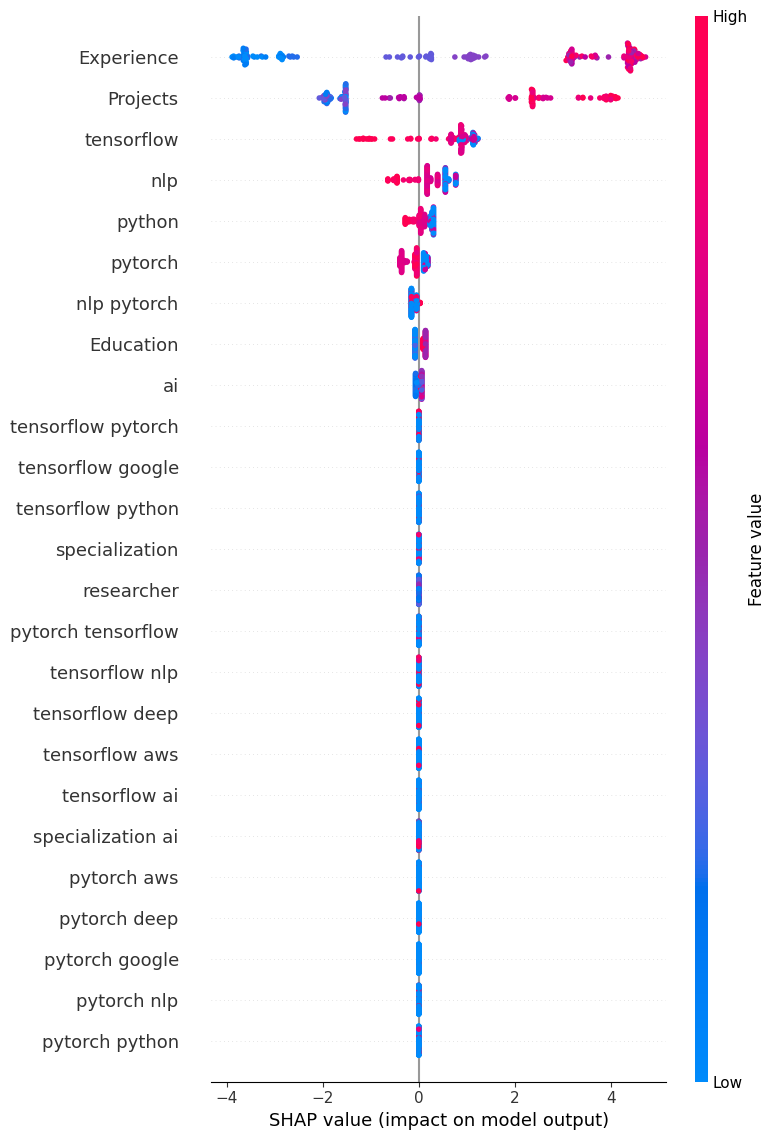

In [7]:
import shap
import random

# Example SHAP explanation for one role
role = 'AI Researcher'
# Use lowercase role name for filename
model = joblib.load(f"model_{role.replace(' ', '_').lower()}.pkl")
vectorizer = joblib.load(f"vectorizer_{role.replace(' ', '_').lower()}.pkl")

df_role = df[df['Job Role'] == role.lower()].copy() # Also filter the DataFrame using lowercase role
text_vec = vectorizer.transform(df_role['combined_text'])

experience = df_role[['Experience (Years)']].astype(float).values
education = df_role[['Education_encoded']].astype(float).values
projects = df_role[['Projects Count']].astype(float).values
experience_scaled = scaler.transform(experience)
projects_scaled = scaler.transform(projects)

experience_sparse = sparse.csr_matrix(experience_scaled)
education_sparse = sparse.csr_matrix(education)
projects_sparse = sparse.csr_matrix(projects_scaled)

X_role = sparse.hstack([text_vec, experience_sparse, education_sparse, projects_sparse])
X_sample = X_role[random.sample(range(X_role.shape[0]), 200)].toarray()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

feature_names = vectorizer.get_feature_names_out().tolist() + ['Experience', 'Education', 'Projects']
shap.summary_plot(shap_values, features=X_sample, feature_names=feature_names, max_display=25)